## 1. Environment

In [2]:
import numpy as np

from copy import copy

## 2. Class Define

In [3]:
class Env:
    def __init__(self):
        self._states = set()
        self._state = None
        self._actions = []
        self._gamma = None
        
    @property
    def states(self):
        return self._states
    
    @property
    def state_space(self):
        return self._state_shape
    
    @property
    def actions(self):
        return self._actions
    
    @property
    def action_space(self):
        return len(self._actions)
    
    @property
    def gamma(self):
        return self._gamma
    
    def _world_init(self):
        raise NotImplementedError
        
    def reset(self):
        raise NotImplementedError
    
    def step(self, state, action):
        """Return distribution and next states"""
        raise NotImplementedError
        
    def set_state(self, state):
        self._state = state


class MatrixEnv(Env):
    def __init__(self, height=4, width=4):
        super().__init__()
        
        self._action_space = 4
        self._actions = list(range(4))
        
        self._state_shape = (2,)
        self._state_shape = (height, width)
        self._states = [(i, j) for i in range(height) for j in range(width)]
        
        self._gamma = 0.9
        self._height = height
        self._width = width

        self._world_init()
        
    @property
    def state(self):
        return self._state
    
    @property
    def gamma(self):
        return self._gamma
    
    def set_gamma(self, value):
        self._gamma = value
        
    def reset(self):
        self._state = self._start_point
        
    def _world_init(self):
        # start_point
        self._start_point = (0, 0)
        self._end_point = (self._height - 1, self._width - 1)
        
    def _state_switch(self, act):
        # 0: h - 1, 1: w + 1, 2: h + 1, 3: w - 1
        if act == 0:  # up
            self._state = (max(0, self._state[0] - 1), self._state[1])
        elif act == 1:  # right
            self._state = (self._state[0], min(self._width - 1, self._state[1] + 1))
        elif act == 2:  # down
            self._state = (min(self._height - 1, self._state[0] + 1), self._state[1])
        elif act == 3:  # left
            self._state = (self._state[0], max(0, self._state[1] - 1))

    def step(self, act):
        assert 0 <= act <= 3
        
        done = False
        reward = 0.

        self._state_switch(act)
        
        if self._state == self._end_point:
            reward = 1.
            done = True

        return None, done, [reward], [self._state]

In [4]:
class ValueTable:
    def __init__(self, env):
        self._shape = env.state_space
        self._values = np.zeros(self._shape)
        self._lazy_values = np.zeros(self._shape)
        
    def lazy_update(self, s, value):
        self._lazy_values[s] = value
    
    def finish_lazy(self):
        # print(self._lazy_values)
        self._values = self._lazy_values
        self._lazy_values = np.zeros(self._shape)
        
    def update(self, s, value):
        self._values[s] = value
        
    def get(self, state):
        if type(state) == list:
            # loop get
            res = [self._values[s] for s in state]
            return res
        elif type(state) == tuple:
            # return directly
            return self._values[state]

In [5]:
from collections import namedtuple


Pi = namedtuple('Pi', 'act, prob')


class Policies:
    def __init__(self, env: Env):
        self._actions = env.actions
        self._default_policy = [1 / env.action_space] * env.action_space
        self._policies = dict.fromkeys(env.states, Pi(self._actions, self._default_policy))
    
    def sample(self, state):
        if self._policies.get(state, None) is None:
            self._policies[state] = Pi(self._actions, self._default_policy)

        policy = self._policies[state]
        return np.random.choice(policy.act, p=policy.prob)
    
    def retrieve(self, state):
        return self._policies[state].prob
    
    def update(self, state, policy):
        self._policies[state] = self._policies[state]._replace(prob=policy)

## 3. Iteration Functions Define

In [6]:
def policy_eval(env: MatrixEnv, values: ValueTable, policies: Policies, upper_bound: float) -> None:
    
    ## counter
    iter = 0
    
    delta = upper_bound * 2
    
    while delta >= upper_bound:
        
        ## set delta
        delta = 0
    
        for s in env.states:
            ## Get v    
            v = values.get(s)

            ## Get V(s)
            env.set_state(s)
            probs = policies.retrieve(s)

            V_s = 0
            for act in env.actions:
                env.set_state(s)
                _, _, r, states = env.step(act)
                # print(f'im strange {states} and reward is {r}')
                v_prime = values.get(env.state)
                # print(f'im now at {env.state}')

                ## Note here my leads to looop

                ## Bellman Equation
                V_s += probs[act] * (r[0] + env.gamma * v_prime)
                
            values.lazy_update(s, V_s)

            delta = max(delta, abs(v - V_s))
            
        # print(delta)
            
        values.finish_lazy()
        
        iter += 1
        
        # print('\r> iteration: {} delta: {}'.format(iter, delta), flush=True, end="")


In [7]:
def policy_improve(env: MatrixEnv, values: ValueTable, policies: Policies) -> bool:
    
    stable = True
    
    for s in env.states:
        
        probs = policies.retrieve(s)
        
        sums = []
        
        for act in env.actions:
            
            env.set_state(s)
            _, _, r, states = env.step(act)
            
            v_prime = values.get(env.state)
            
            sums.append(probs[act] * (r[0] + env.gamma * v_prime))
            
        better_act_tmp = env.actions[np.argmax(sums)]
        
        equal_better_acts = []
        
        for i in range(env.action_space):
            if sums[i] == sums[better_act_tmp]:
                equal_better_acts.append(i)
        
        new_policy = [0] * env.action_space
        
        for act in equal_better_acts:
            new_policy[act] = 1/len(equal_better_acts)
        
        policies.update(s, new_policy)
        
        for i in range(len(probs)):
            if probs[i] != new_policy[i]:
                stable = False
                
            # print(probs, '~~~', new_policy)
            
        ## 需要单步调试 看看哪里出问题了
        
                
    return stable
    
    # pi(s) is an approximate action

In [31]:
def value_iter(env: MatrixEnv, values: ValueTable, upper_bound: float) -> None:
    
    ## counter
    iters = 0
    
    delta = 2 * upper_bound
    
    while delta >= upper_bound:
        
        ## set delta
        delta = 0
        
        # tempv = np.zeros(env.state_space)
    
        for s in env.states:
            ## Get v    
            v = values.get(s)

            ## Get V(s)
            env.set_state(s)
            # probs = policies.retrieve(s)

            V_s = 0
            
            for act in env.actions:
                env.set_state(s)
                _, _, r, states = env.step(act)
                # print(f'im strange {states} and reward is {r}')
                v_prime = values.get(env.state)
                # print(f'im now at {env.state}')

                ## Note here my leads to looop

                ## Bellman Equation
                V_s = max(V_s, r[0] + env.gamma * v_prime)
                # tempv[s]=maximun
                
                
            values.lazy_update(s, V_s)

            delta = max(delta, abs(v - V_s))
            
        # print(delta)
            
        values.finish_lazy()
        
        # for s in env.states: 
        #     values.update(s=s,value=tempv[s])
        
        iters += 1
    
    return iters
    # print('\r> iteration: {} delta: {}'.format(iter, delta), flush=True, end="")
    


In [9]:
import time

env = MatrixEnv(width=8, height=8)  # TODO(ming): try different word size
policies = Policies(env)
values = ValueTable(env)
upper_bound = 1e-4

stable = False

start = time.time()

iter = 0
while not stable:
    policy_eval(env, values, policies, upper_bound)
    # print('imhere')
    stable = policy_improve(env, values, policies)
    iter += 1
print(iter)
    

end = time.time()

print('\n[time consumpution]: {} s'.format(end - start))

done = False
rewards = 0
env.reset()
step = 0

while not done:
    act_index = policies.sample(env.state)
    _, done, reward, next_state = env.step(env.actions[act_index])
    rewards += sum(reward)
    step += 1

print('Evaluation: [reward] {} [step] {}'.format(rewards, step))

2

[time consumpution]: 0.06930065155029297 s
Evaluation: [reward] 1.0 [step] 14


In [10]:
env = MatrixEnv(width=8, height=8)  # try different word size
policies = Policies(env)
values = ValueTable(env)
upper_bound = 1e-4

start = time.time()
value_iter(env, values, upper_bound)

# print(values._values)

_ = policy_improve(env, values, policies)
end = time.time()

print('\n[time consumption] {}s'.format(end - start))
# print("===== Render =====")
env.reset()
done = False
rewards = 0
step = 0
while not done:
    act_index = policies.sample(env.state)
    _, done, reward, next_state = env.step(env.actions[act_index])
    rewards += sum(reward)
    step += 1

print('Evaluation: [reward] {} [step] {}'.format(rewards, step))



> iteration: 89 delta: 9.404610870067387e-05
[time consumption] 0.07536077499389648s
Evaluation: [reward] 1.0 [step] 14


In [37]:
import time

def test_policy(wh: int):

    env = MatrixEnv(width=wh, height=wh)  # TODO(ming): try different word size
    policies = Policies(env)
    values = ValueTable(env)
    upper_bound = 1e-4

    stable = False

    iters = 0
    start = time.time()
    while not stable:
        policy_eval(env, values, policies, upper_bound)
        stable = policy_improve(env, values, policies)
        iters += 1
    end = time.time()
    print(iters)


    # print('\n[time consumpution]: {} s'.format(end - start))

    done = False
    rewards = 0
    env.reset()
    step = 0

    while not done:
        act_index = policies.sample(env.state)
        _, done, reward, next_state = env.step(env.actions[act_index])
        rewards += sum(reward)
        step += 1

    # print('Evaluation: [reward] {} [step] {}'.format(rewards, step))
    
    return iters, end-start, rewards, step

In [12]:
def test_value(wd: int):

    env = MatrixEnv(width=wd, height=wd)  # try different word size
    policies = Policies(env)
    values = ValueTable(env)
    upper_bound = 1e-4

    start = time.time()
    iters = value_iter(env, values, upper_bound)
    _ = policy_improve(env, values, policies)
    end = time.time()

    # print('\n[time consumption] {}s'.format(end - start))
    # print("===== Render =====")
    env.reset()
    done = False
    rewards = 0
    step = 0
    while not done:
        act_index = policies.sample(env.state)
        _, done, reward, next_state = env.step(env.actions[act_index])
        rewards += sum(reward)
        step += 1

    # print('Evaluation: [reward] {} [step] {}'.format(rewards, step))
    return iters, end-start, rewards, step

In [52]:
policy_iter = []
policy_time = []
policy_reward = []
policy_step = []

nums = []

for i in range(4, 100):
    iters, time_cost, rewards, step = test_policy(i)
    nums.append(i)
    policy_iter.append(iters)
    policy_time.append(time_cost)
    policy_reward.append(rewards)
    policy_step.append(step)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
4
3
3
3
3
3
3
3
3
4
4
5
5
5
6
5
5
6
7
6
8
7
7
7
6
5
5
4
5
4
4
5
6
8
10
11
13


In [53]:
value_iters = []
value_time = []
value_reward = []
value_step = []
nums = []

for i in range(4, 100):
    iters, time_cost, rewards, step = test_value(i)
    nums.append(i)
    value_iters.append(iters)
    value_time.append(time_cost)
    value_reward.append(rewards)
    value_step.append(step)

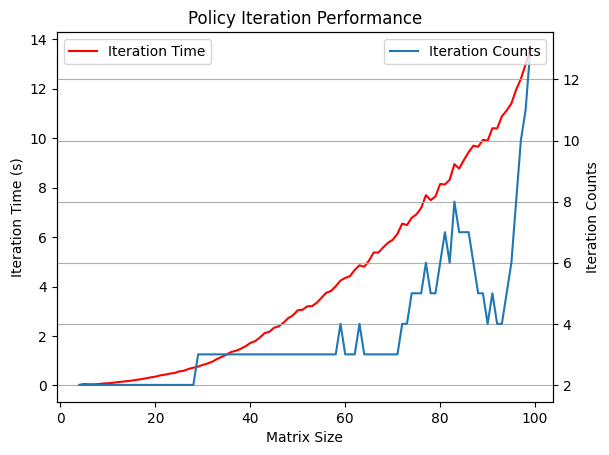

In [54]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot()

ax.plot(nums, policy_time, label='Iteration Time', color='r')
ax.set_ylabel('Iteration Time (s)')
ax.legend(loc='upper left')
# ax.set_ylim(0, 40)

ax2 = ax.twinx()
ax2.plot(nums, policy_iter, label='Iteration Counts')
ax2.set_ylabel("Iteration Counts")
# ax2.set_ylim(60, 100)
ax2.legend(loc='upper right')

ax.set_xlabel("Matrix Size")

plt.title('Policy Iteration Performance')
plt.grid()
plt.show()

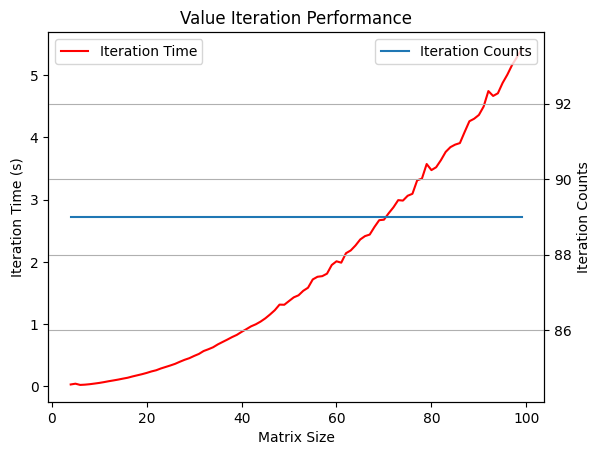

In [55]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot()

ax.plot(nums, value_time, label='Iteration Time', color='r')
ax.set_ylabel('Iteration Time (s)')
ax.legend(loc='upper left')
# ax.set_ylim(0, 40)

ax2 = ax.twinx()
ax2.plot(nums, value_iters, label='Iteration Counts')
ax2.set_ylabel("Iteration Counts")
# ax2.set_ylim(60, 100)
ax2.legend(loc='upper right')

ax.set_xlabel("Matrix Size")

plt.title('Value Iteration Performance')
plt.grid()
plt.show()

In [41]:
print(policy_step)

[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46]


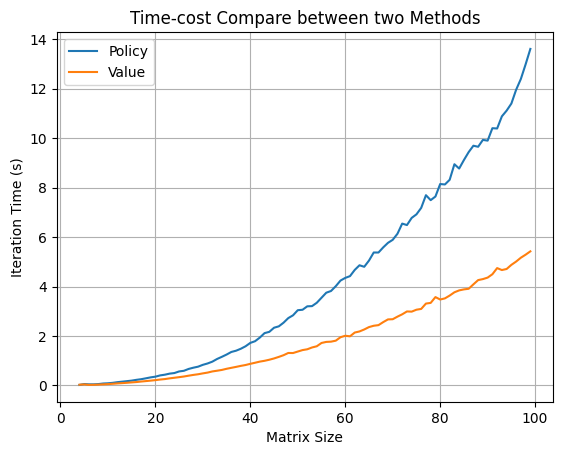

In [56]:
plt.plot(nums, policy_time, label='Policy')

plt.plot(nums, value_time, label='Value')

plt.title('Time-cost Compare between two Methods')
plt.xlabel('Matrix Size')
plt.ylabel('Iteration Time (s)')

plt.legend()

plt.grid()

plt.show()

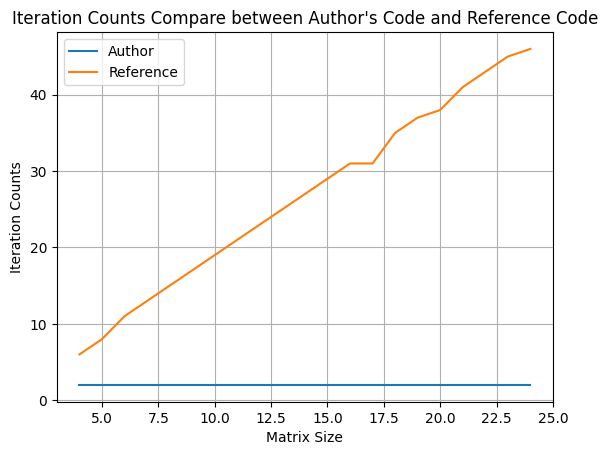

In [61]:
ref_policy_iter = [6,8,11,13,15,17,19,21,23,25,27,29,31,31,35,37,38,41,43,45,46]


plt.plot(nums[0:21], policy_iter[0:21], label='Author')

plt.plot(nums[0:21], ref_policy_iter, label='Reference')

plt.title('Iteration Counts Compare between Author\'s Code and Reference Code')
plt.xlabel('Matrix Size')
plt.ylabel('Iteration Counts')

plt.legend()

plt.grid()

plt.show()

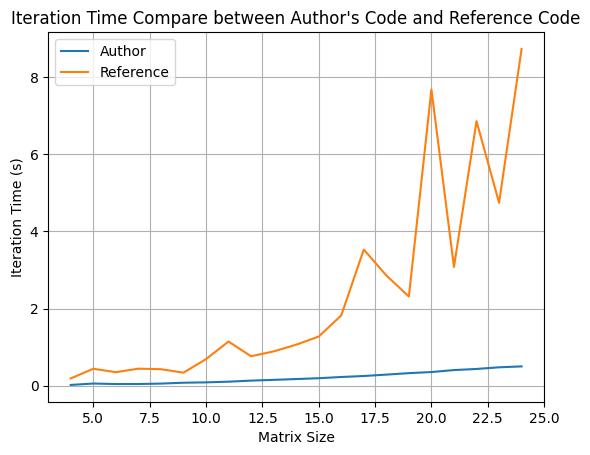

In [62]:
ref_policy_time = [0.1890583038330078,0.44042181968688965,0.35162854194641113,0.4422125816345215,0.42902040481567383,0.3390920162200928,0.688941478729248,1.1454932689666748,0.7646441459655762,0.8901810646057129,1.0634267330169678,1.2749803066253662,1.822641134262085,3.5299253463745117,2.859572649002075,2.312700033187866,7.67841362953186,3.0791311264038086,6.858690500259399,4.742274522781372,8.730968713760376]


plt.plot(nums[0:21], policy_time[0:21], label='Author')

plt.plot(nums[0:21], ref_policy_time, label='Reference')

plt.title('Iteration Time Compare between Author\'s Code and Reference Code')
plt.xlabel('Matrix Size')
plt.ylabel('Iteration Time (s)')

plt.legend()

plt.grid()

plt.show()